In [41]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score



### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [5]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [6]:
df.index = list(range(len(df.happy)))

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [67]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04369885433715221
Percent Type II errors: 0.16988543371522094

Test set accuracy:
Percent Type I errors: 0.05694648993618066
Percent Type II errors: 0.1953853706431026


In [68]:
clf.score(X_test, y_test)

0.74766813942071675

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

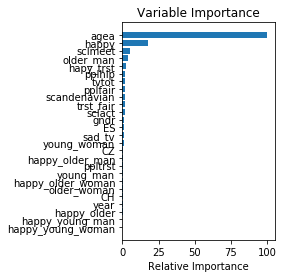

In [69]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [44]:
df2 = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)
df2['scandenavian'] = [1 if ctry in ['SE', 'DE', 'NO'] else 0 for ctry in df2['cntry']]
df2['gndr'] = df2['gndr']-1

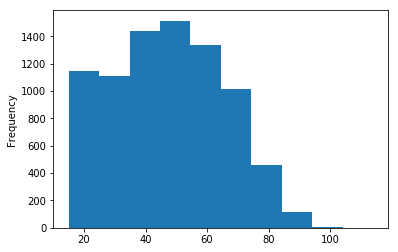

In [139]:
df2.agea.plot.hist()

In [45]:
df2['sad_tv'] = [1 if ((df2['happy'][ind]<=6) & (df2['tvtot'][ind]>=3)) else 0 for ind in range(len(df2['happy']))]
df2['happy_older_man'] = [1 if ((df2['happy'][ind]>=6) & (df2['gndr'][ind]==1) & (df2['agea'][ind]>60)) else 0 for ind in range(len(df2['happy']))]
df2['happy_older_woman'] = [1 if ((df2['happy'][ind]>=6) & (df2['gndr'][ind]==0) & (df2['agea'][ind]>60)) else 0 for ind in range(len(df2['happy']))]
df2['happy_older'] = [1 if ((df2['happy'][ind]>=6) & (df2['agea'][ind]>60)) else 0 for ind in range(len(df2['happy']))]
df2['happy_young_man'] = [1 if ((df2['happy'][ind]>=6) & (df2['gndr'][ind]==1) & (df2['agea'][ind]<30)) else 0 for ind in range(len(df2['happy']))]
df2['happy_young_woman'] = [1 if ((df2['happy'][ind]>=6) & (df2['gndr'][ind]==0) & (df2['agea'][ind]<30)) else 0 for ind in range(len(df2['happy']))]
df2['older_man'] = [1 if ((df2['gndr'][ind]==1) & (df2['agea'][ind]>60)) else 0 for ind in range(len(df2['happy']))]
df2['older_woman'] = [1 if ((df2['gndr'][ind]==0) & (df2['agea'][ind]>60)) else 0 for ind in range(len(df2['happy']))]
df2['young_woman'] = [1 if ((df2['gndr'][ind]==0) & (df2['agea'][ind]<30)) else 0 for ind in range(len(df2['happy']))]
df2['young_man'] = [1 if ((df2['gndr'][ind]==1) & (df2['agea'][ind]<30)) else 0 for ind in range(len(df2['happy']))]
df2['hapy_trst'] = df2['happy']*df2['ppltrst']
df2['trst_fair'] = df2['ppltrst']*df2['pplfair']

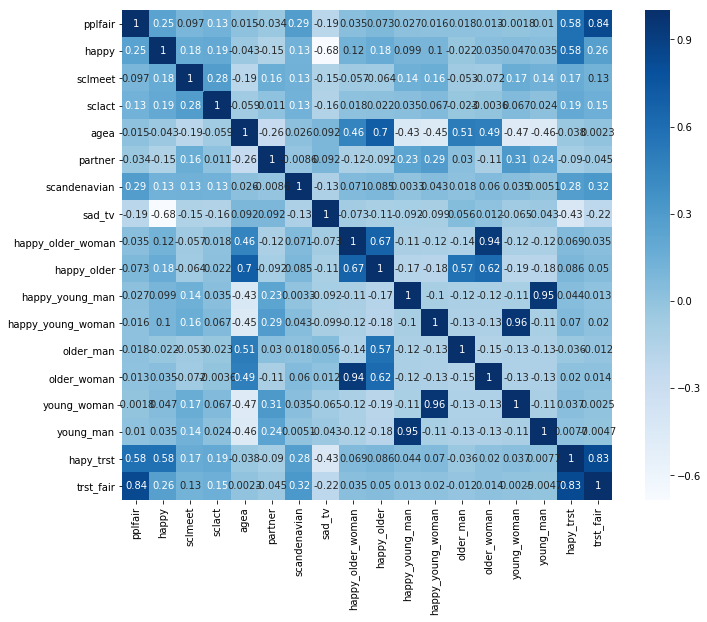

In [84]:
corrmat = df2.loc[:, ~df2.columns.isin(['SE','CH','ES','happy_older_man','ppltrst', 'pplhlp','DE', 'NO','CZ', 'cntry', 'tvtot','idno', 'year', 'gndr'])].corr()#alt_X_df.corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True, annot=True,cmap='Blues')

In [46]:
# X = df2.loc[:, ~df2.columns.isin(['SE','CH','ES','happy_older_man', 'pplhlp','DE', 'NO','CZ', 'cntry', 'tvtot','idno', 'year', 'gndr', 'partner'])]#alt_X_df.corr()
# df2 = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)
X = df2.loc[:, ~df2.columns.isin(['SE', 'DE', 'NO', 'cntry', 'idno', 'partner'])]
Y = df2['partner']-1

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=3)

In [48]:
# based on work below to identify best parameter set:

params = {'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 400,
 'subsample': 0.8,
 'tol': 0.0001}

#
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, 
# criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
# max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, 
# max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, 
# n_iter_no_change=None, tol=0.0001)

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)

clf2.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.1, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [49]:
predict_train = clf2.predict(X_train)
predict_test = clf2.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.05253682487725041
Percent Type II errors: 0.1806873977086743

Test set accuracy:
Percent Type I errors: 0.056455571919489446
Percent Type II errors: 0.19882179675994108


In [50]:
cross_val_score(clf2,X_test, y_test, cv = 10)

array([ 0.75609756,  0.70731707,  0.72682927,  0.74019608,  0.74876847,
        0.70935961,  0.77832512,  0.74384236,  0.65024631,  0.74384236])

# For Comparison:
Training set accuracy:  
Percent Type I errors: 0.0469721767594108  
Percent Type II errors: 0.17201309328968903  

Test set accuracy:  
Percent Type I errors: 0.058419243986254296  
Percent Type II errors: 0.19145802650957292  

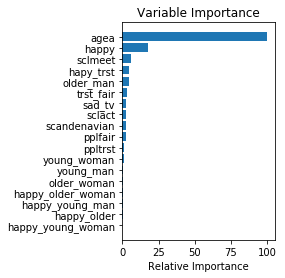

In [57]:
feature_importance = clf2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

 ## Run Parameter grid search to find optimal parameter set

In [10]:
params = {'loss': ['deviance','exponential'],
          'learning_rate':[.005, .01, 0.1,.2],
          'n_estimators': [400],
          'subsample': [.8, .9,1],
          'min_samples_split':[2,3],
          'min_weight_fraction_leaf': [0,.1,.2,.5],
          'max_depth': [2,3],
          'tol':[0.00001, 0.0001]
          }

#
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, 
# criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
# max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, 
# max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, 
# n_iter_no_change=None, tol=0.0001)

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf = GridSearchCV(clf2, params, cv=5, n_jobs= -1)

clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=[0.005, 0.01, 0.1, 0.2],
              loss=['deviance', 'exponential'], max_depth=[2, 3],
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity...            tol=[1e-05, 0.0001], validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.005, 0.01, 0.1, 0.2], 'n_estimators': [400], 'subsample': [0.8, 0.9, 1], 'min_samples_split': [2, 3], 'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.5], 'max_depth': [2, 3], 'tol': [1e-05, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
print("Best parameters set found on development set:")
print()
print(clf.best_estimator_)

Best parameters set found on development set:

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.1, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [13]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.05223677032187671
Percent Type II errors: 0.18562465902891434

Test set accuracy:
Percent Type I errors: 0.07484662576687116
Percent Type II errors: 0.1754601226993865


In [14]:
clf.score(X_test, y_test)

0.74969325153374233

In [16]:
clf.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 400,
 'subsample': 0.8,
 'tol': 0.0001}

In [18]:
params = {'learning_rate': [0.1],
 'loss': ['deviance'],
 'max_depth': [2],
 'min_samples_split': [2],
 'min_weight_fraction_leaf': [0.1],
 'n_estimators': [400, 500, 600, 800],
 'subsample': [0.8],
 'tol': [0.0001]}

clf3 = ensemble.GradientBoostingClassifier(**params)
clf4 = GridSearchCV(clf3, params, cv=5, n_jobs= -1)

clf4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=[0.1], loss=['deviance'], max_depth=[2],
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min....8],
              tol=[0.0001], validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1], 'loss': ['deviance'], 'max_depth': [2], 'min_samples_split': [2], 'min_weight_fraction_leaf': [0.1], 'n_estimators': [400, 500, 600, 800], 'subsample': [0.8], 'tol': [0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
clf4.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 400,
 'subsample': 0.8,
 'tol': 0.0001}

In [20]:
predict_train = clf4.predict(X_train)
predict_test = clf4.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0533278777959629
Percent Type II errors: 0.1848063284233497

Test set accuracy:
Percent Type I errors: 0.07607361963190185
Percent Type II errors: 0.17300613496932515


In [21]:
clf4.score(X_test, y_test)

0.750920245398773